# Pairwise thermal classification (baseline vs candidate)


This notebook builds a simple model that compares each image to a normal baseline from the same transformer (data/T*/normal vs data/T*/faulty).


Notes:

- Approach: create a per-transformer baseline (median of all normal images), extract difference features between a candidate and its baseline (legend-aware), and train a small classifier.
- This avoids mixing all transformers together; comparisons are intra-transformer, which is more robust to hardware/background variations.

The following rules, guidelines and table were provided to us and are not created by us.

## Rules

There are two types of abnormal situations observed in the dataset: loose joints and overloads. 

 1. Loose Joint Condition 

    A loose joint creates a hotspot at the connection point. 

- Faulty: If the middle of the joint appears reddish or orange-yellowish, compared to a blue/black background, it is a clear fault.

- Potentially Faulty: If the middle of the joint is yellowish (not reddish or orange) compared to the blue/black background, it is potentially faulty. 


2. Overloaded Condition

    Overloading causes heating along a wire.  

- Point Overload (Faulty): If a small point or small area on the wire appears reddish or orange-yellowish, while the rest of the wire is in black/blue or yellowish, it is a faulty case.  

- Point Overload (Potentially Faulty): If a small point or small area on the wire appears yellowish, while the rest of the wire is in black/blue, it is a potentially faulty case.

- Full Wire Overload (Potentially Faulty): If the entire wire appears in reddish or yellowish colors, it is considered potentially faulty. This could be due to operational load rather than a permanent fault.  

## Guidelines

1. Always compare the hotspot area with its background. A valid anomaly appears when a reddish or yellowish spot contrasts with a mostly blue/black background. When we say “background”, we don’t mean the background of the transformer (e.g., sky, building, or trees). This is the background of the relevant component in the thermal image (parts of the transformer).

2. Use the color intensity and distribution to classify the image into one of the categories:  
   - Normal  
   - Faulty (loose joint/point overload)  
   - Potentially Faulty (yellowish loose joint or full wire overload)  
3. If uncertain, focus on whether the contrast with the background clearly indicates abnormal heating.

4. Objective is to minimize fault negatives because false positives go through a human verification step, but false negatives do not!  

## Summary Table of Thermal Image Analysis

| Condition                | Thermal Image Appearance                                                             | Classification        |
|---------------------------|---------------------------------------------------------------------------------------|-----------------------|
| Normal                   | Mostly black/blue, no reddish or yellowish spots                                       | Normal                |
| Loose Joint (Faulty)     | Middle area reddish / orange-yellowish, background blue/black                          | Faulty                |
| Loose Joint (Potential)  | Middle area yellowish (not reddish/orange), background blue/black                      | Potentially Faulty    |
| Point Overload (Faulty)  | Small spot reddish / orange-yellowish, rest of the wire black/blue or yellowish        | Faulty                |
| Point Overload (Potential)| Small spot yellowish, rest of the wire black/blue                                     | Potentially Faulty    |
| Full Wire Overload       | The entire wire is reddish or yellowish                                               | Potentially Faulty    |


In [1]:
import cv2 as cv
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from helpers import (
    ensure_bgr,
    shorten_path,
    hs_histogram,
    detect_fault_regions,
    draw_boxes,
    compute_baseline_for_transformer
)

DATA_ROOT = Path('data')

## Simplified warm-spot detection and plotting


This section:

- Builds a baseline from normal images per transformer.

- Flags warm regions (red, yellow, orange) that exceed the baseline.

- Draws red rectangles around detected warm areas.

- Plots results for review.

In [2]:
def plot_detected_faults(data_root: Path, rows:int, cols:int)  :
    faulty_total = 0
    normal_total = 0
    faulty_correct = 0
    normal_correct = 0
    transformers = sorted([p for p in data_root.glob('T*') if p.is_dir()])
    results = []
    for t in transformers:
        try:
            baseline = compute_baseline_for_transformer(t)
        except Exception as e:
            print(f"Skip {t.name}: {e}")
            continue
        candidates = sorted((t/'faulty').glob('*.*')) + sorted((t/'normal').glob('*.*'))
        for p in candidates:
            if ("faulty" in str(p)):
                faulty_total += 1
            else:
                normal_total += 1
            img = cv.imread(str(p), cv.IMREAD_UNCHANGED)
            if img is None:
                continue
            bgr = ensure_bgr(img)
            warm_mask, boxes = detect_fault_regions(bgr, baseline)
            if ("faulty" in str(p)) and (len(boxes) > 0):
                faulty_correct += 1
            if ("normal" in str(p)) and (len(boxes) == 0):
                normal_correct += 1
            vis = draw_boxes(bgr, boxes)
            results.append((str(p), vis, boxes))
    N = len(results)
    if N == 0:
        print('No images to show.')
        return
    fig, axes = plt.subplots(rows, cols, figsize=(5*3.2, 4*3.2))
    axes = np.array(axes).reshape(-1) if 4*5>1 else np.array([axes])
    for i, ax in enumerate(axes):
        if i < N:
            p, vis, boxes = results[i]
            rgb = cv.cvtColor(vis, cv.COLOR_BGR2RGB)
            ax.imshow(rgb)
            if len(boxes)>0:
                title = "Faulty"
            else:
                title = "Normal"
            ax.set_title(title, fontsize=9)
            if 'shorten_path' in globals():
                ax.set_xlabel(shorten_path(p), fontsize=7)
            ax.set_xticks([]); ax.set_yticks([])
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()
    print(f"Faulty accuracy: {faulty_correct}/{faulty_total} = {faulty_correct/faulty_total:.3f}" if faulty_total>0 else "No faulty samples")
    print(f"Normal accuracy: {normal_correct}/{normal_total} = {normal_correct/normal_total:.3f}" if normal_total>0 else "No normal samples")

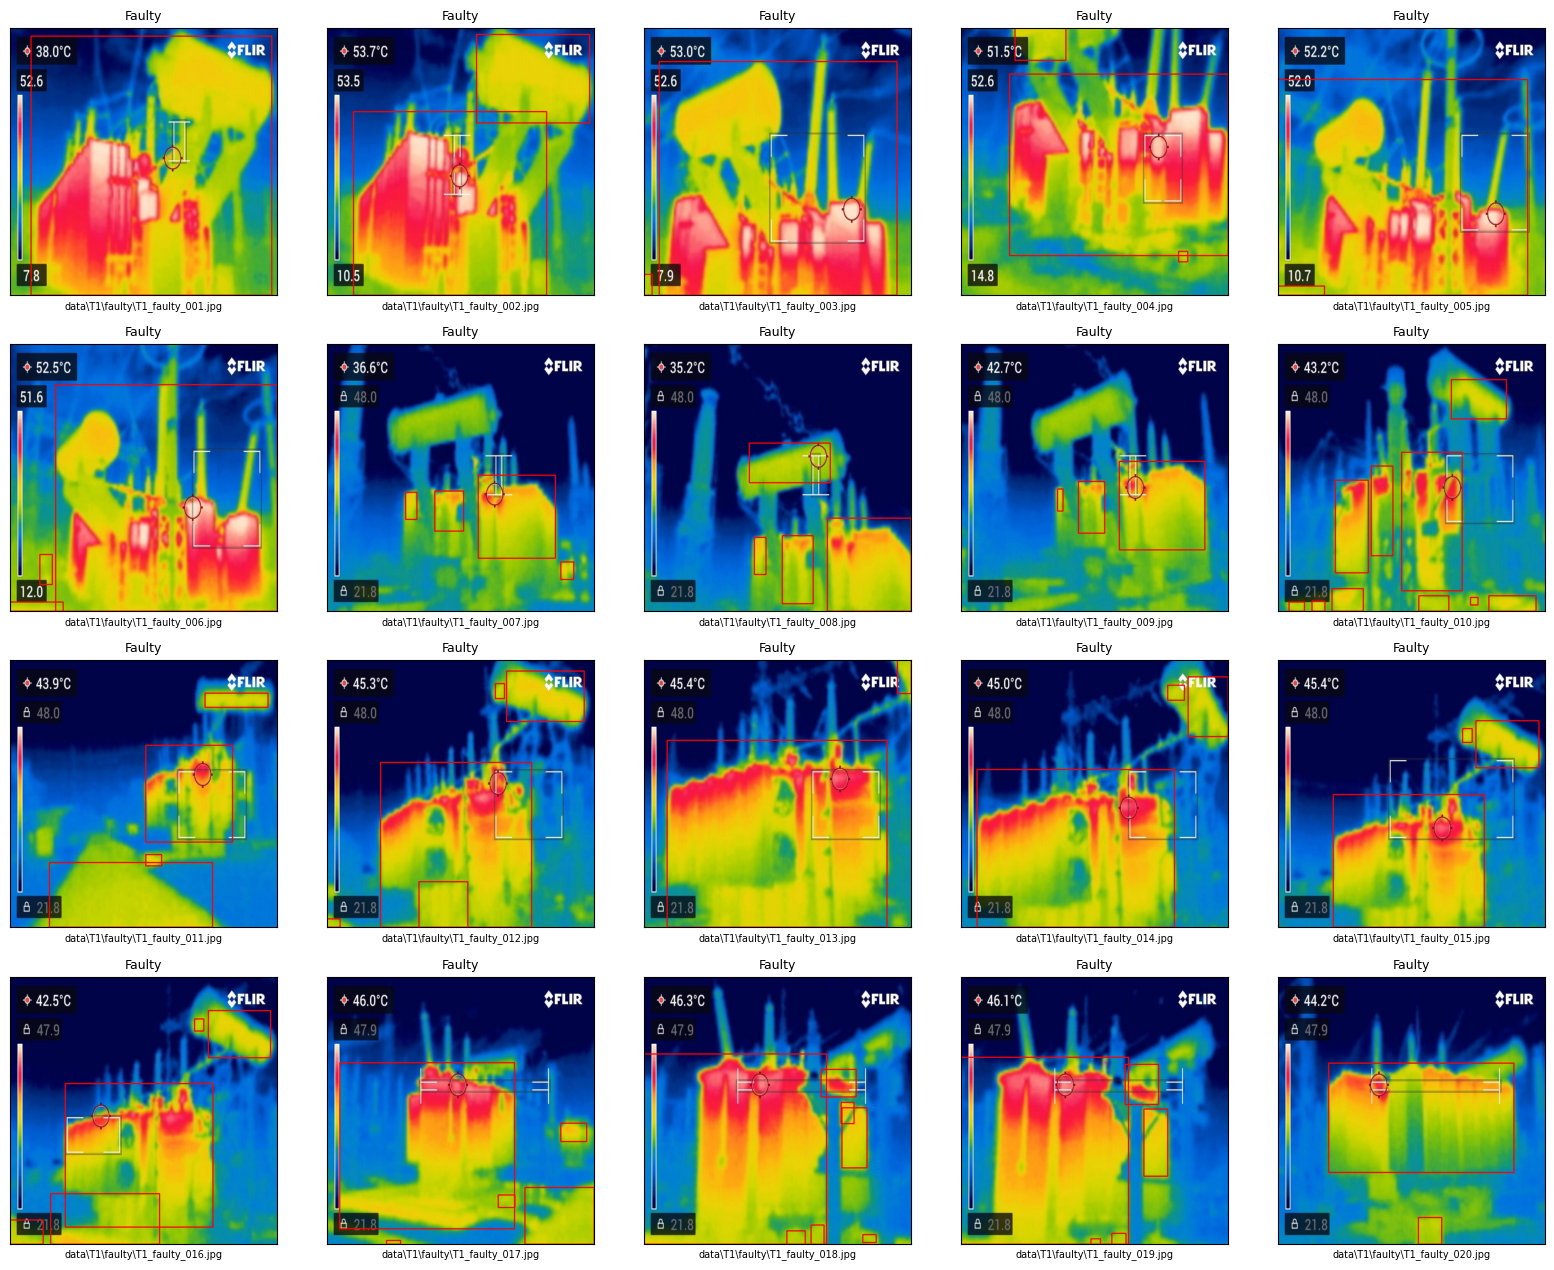

Faulty accuracy: 65/70 = 0.929
Normal accuracy: 27/36 = 0.750


In [3]:
plot_detected_faults(DATA_ROOT, rows=4, cols=5)

## Histogram + brightness lift + warm area features

- Builds a median baseline image from each transformer's normal images.

- Extracts features per normal image:
  - HS histogram over the entire image (color distribution).
  - Brightness lift vs baseline: 95th percentile of V-channel difference (dv95).
  - Warm-area fraction above baseline using warm mask (red/yellow).

- Aggregates mean/std of these features to form the normal reference model.

- Later, a candidate image is scored by comparing its features to the model (converted to z-scores and combined).

In [4]:
def z_distance_hist(hvec: np.ndarray, mean_vec: np.ndarray, std_vec: np.ndarray, eps: float = 1e-6) -> float:
    """Scale-invariant distance between histogram hvec and normal mean/std.
    Computes RMS z-score across bins: sqrt(mean(((h-mean)/std)^2))."""
    hvec = np.asarray(hvec, dtype=np.float32)
    mean_vec = np.asarray(mean_vec, dtype=np.float32)
    std_vec = np.asarray(std_vec, dtype=np.float32)
    z = (hvec - mean_vec) / (std_vec + eps)
    return float(np.sqrt(np.mean(z * z)))

def build_normal_color_models(data_root: Path) -> dict:
    """Build per-transformer normal models (baseline + color/brightness stats).
    Uses HS histograms, V-channel dv95, and warm-area fraction.
    Returns a dict keyed by transformer path (str)."""
    models = {}
    transformers = sorted([p for p in data_root.glob('T*') if p.is_dir()])
    for t in transformers:
        normal_paths = sorted((t / 'normal').glob('*.*'))
        if not normal_paths:
            continue
        imgs = []
        for p in normal_paths:
            img = cv.imread(str(p), cv.IMREAD_UNCHANGED)
            if img is None:
                continue
            imgs.append(ensure_bgr(img))
        if not imgs:
            continue
        # Baseline: median of resized normals (to first image size)
        H0, W0 = imgs[0].shape[:2]
        stack = np.stack([cv.resize(im, (W0, H0), interpolation=cv.INTER_AREA) for im in imgs], 0)
        baseline = np.median(stack, axis=0).astype(np.uint8)
        # Collect per-image features
        hists = []
        dv95s = []
        warm_fracs = []
        for bgr in imgs:
            # Color distribution (no legend masking)
            hists.append(hs_histogram(bgr))
            # Brightness lift (V-channel) vs baseline
            H,W = bgr.shape[:2]
            base = cv.resize(baseline, (W, H), interpolation=cv.INTER_AREA)
            v_img = cv.cvtColor(bgr, cv.COLOR_BGR2HSV)[:, :, 2].astype(np.float32) / 255.0
            v_base = cv.cvtColor(base, cv.COLOR_BGR2HSV)[:, :, 2].astype(np.float32) / 255.0
            dv95s.append(float(np.quantile(v_img - v_base, 0.95)))
            # Warm fraction (new warm vs baseline)
            warm_mask, _ = detect_fault_regions(bgr, baseline, min_area_frac=0.0005)
            warm_fracs.append(float(np.count_nonzero(warm_mask)) / (H * W))
        hists = np.stack(hists, 0).astype(np.float32)
        hs_mean = hists.mean(axis=0)
        hs_std = hists.std(axis=0) + 1e-6
        dv_p95_mean = float(np.mean(dv95s))
        dv_p95_std = float(np.std(dv95s) + 1e-6)
        warm_frac_mean = float(np.mean(warm_fracs))
        warm_frac_std = float(np.std(warm_fracs) + 1e-6)
        models[str(t)] = {
            'hs_mean': hs_mean,
            'hs_std': hs_std,
            'dv_p95_mean': dv_p95_mean,
            'dv_p95_std': dv_p95_std,
            'warm_frac_mean': warm_frac_mean,
            'warm_frac_std': warm_frac_std,
            'baseline': baseline,
        }
    return models

if 'normal_models' not in globals():
    normal_models = {}

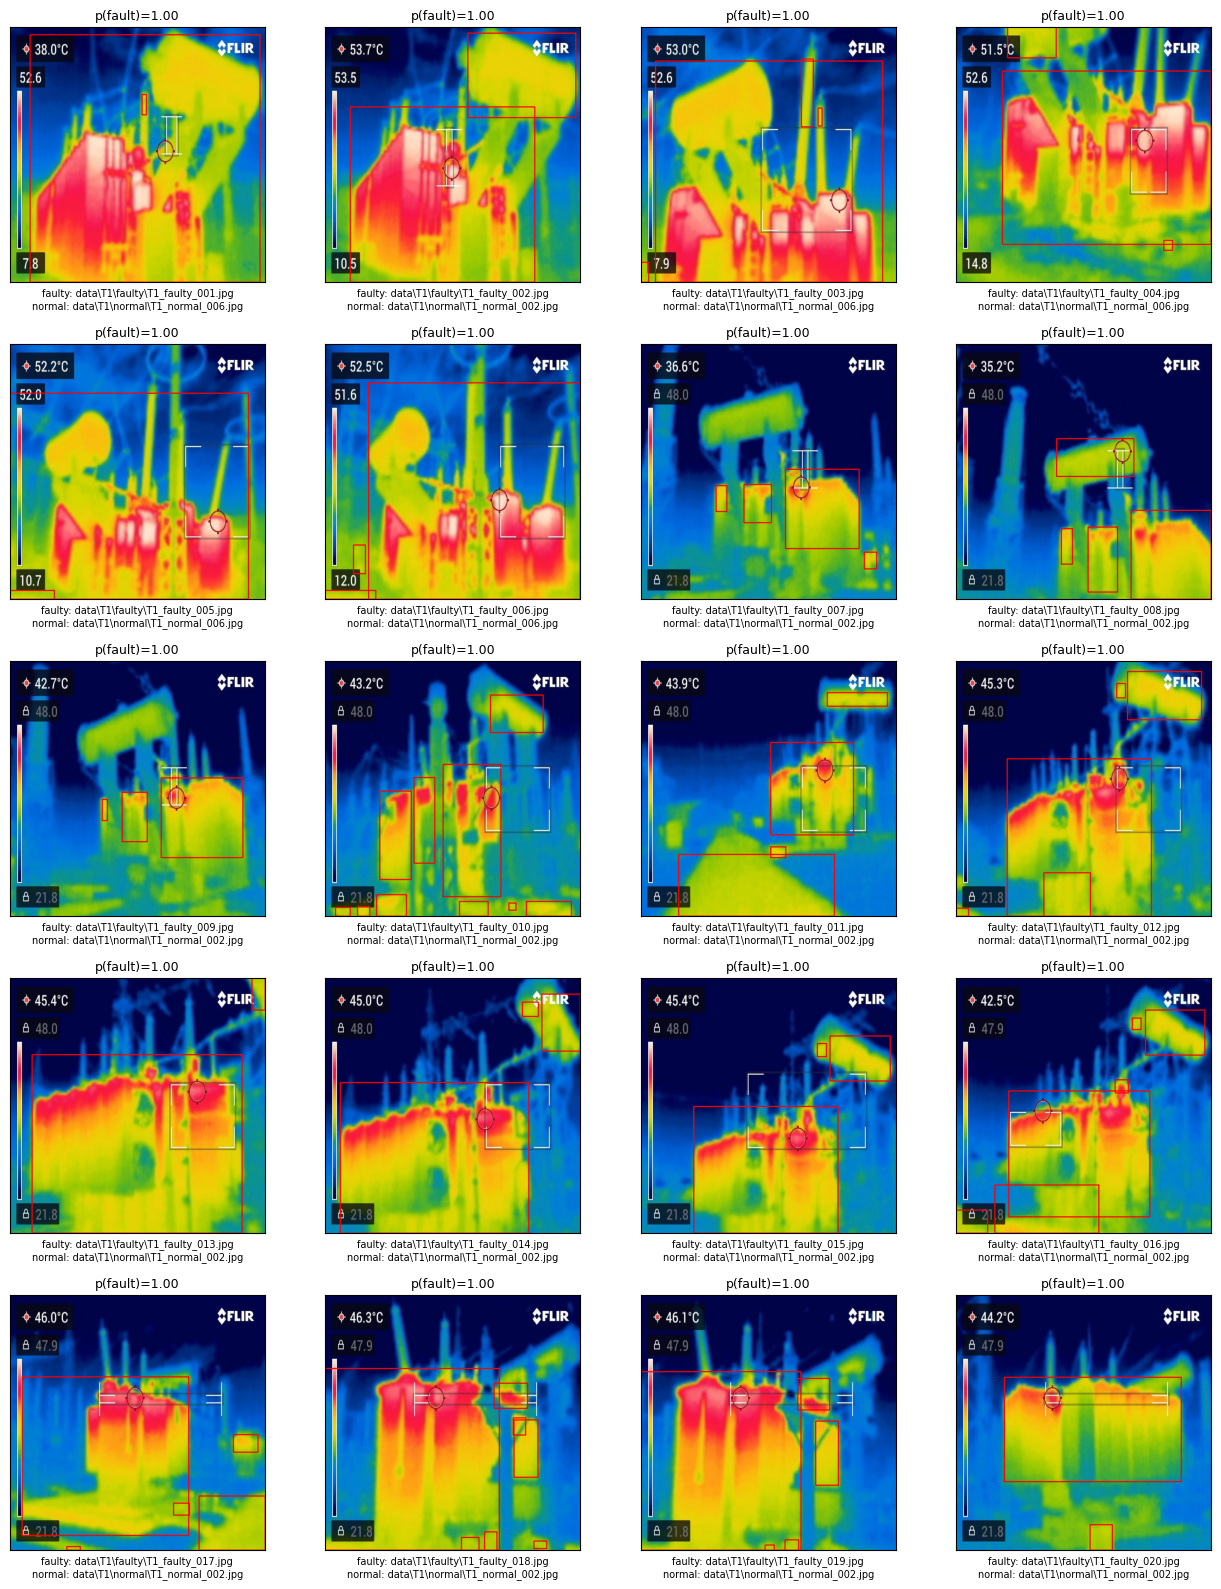

Processed 70 faulty images; displaying 20.
Faulty accuracy: 63/70 = 0.900


In [ ]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def _hist_distance(h1: np.ndarray, h2: np.ndarray) -> float:
    """Simple L2 distance between two normalized histograms."""
    h1 = np.asarray(h1, dtype=np.float32).ravel()
    h2 = np.asarray(h2, dtype=np.float32).ravel()
    return float(np.sqrt(np.sum((h1 - h2) ** 2)))

def select_corresponding_normal(t_dir: Path, faulty_path: Path) -> Path | None:
    """Select a corresponding normal image for a given faulty image.
    Strategy: choose the normal image with the closest HS histogram (L2).
    Returns the Path of the selected normal image or None if no normals exist.
    """
    normal_paths = sorted((t_dir / 'normal').glob('*.*'))
    if not normal_paths:
        return None
    f_img = cv.imread(str(faulty_path), cv.IMREAD_UNCHANGED)
    if f_img is None:
        return normal_paths[0]
    f_bgr = ensure_bgr(f_img)
    f_hist = hs_histogram(f_bgr)
    best = None
    best_d = float('inf')
    for npth in normal_paths:
        n_img = cv.imread(str(npth), cv.IMREAD_UNCHANGED)
        if n_img is None:
            continue
        n_bgr = ensure_bgr(n_img)
        n_hist = hs_histogram(n_bgr)
        d = _hist_distance(f_hist, n_hist)
        if d < best_d:
            best_d = d
            best = npth
    return best if best is not None else normal_paths[0]


def fault_probability_for_image_paired(
    t_dir: Path,
    faulty_img_path: str,
    models: dict,
    alpha_hist: float = 1.0,
    alpha_dv: float = 1.0,
    alpha_warm: float = 1.0,
):
    """Compute fault probability for a single faulty image by pairing it with a corresponding normal image.

    - Histogram term: z-distance of faulty histogram from normal-images mean/std (from models[t]).
    - dv95 term: 95th percentile of V-channel difference faulty vs selected-normal.
    - warm term: warm-area fraction detected when comparing faulty vs selected-normal.

    Returns: (prob, boxes, faulty_bgr, selected_normal_path)
    """
    key = str(t_dir)
    if key not in models:
        raise KeyError(f"No model for {t_dir}")
    model = models[key]

    # Load faulty
    f_img = cv.imread(faulty_img_path, cv.IMREAD_UNCHANGED)
    if f_img is None:
        raise FileNotFoundError(faulty_img_path)
    f_bgr = ensure_bgr(f_img)

    # Pick corresponding normal via histogram nearest neighbor
    n_path = select_corresponding_normal(t_dir, Path(faulty_img_path))
    if n_path is None:
        # If no normal, fall back to median baseline logic
        hvec = hs_histogram(f_bgr)
        d_hist = z_distance_hist(hvec, model['hs_mean'], model['hs_std'])
        H, W = f_bgr.shape[:2]
        base = cv.resize(model['baseline'], (W, H), interpolation=cv.INTER_AREA)
        v_f = cv.cvtColor(f_bgr, cv.COLOR_BGR2HSV)[:, :, 2].astype(np.float32) / 255.0
        v_b = cv.cvtColor(base, cv.COLOR_BGR2HSV)[:, :, 2].astype(np.float32) / 255.0
        dv95 = float(np.quantile(v_f - v_b, 0.95))
        z_dv = (dv95 - model['dv_p95_mean']) / model['dv_p95_std']
        warm_mask, boxes = detect_fault_regions(f_bgr, model['baseline'], min_area_frac=0.0005)
        warm_frac = float(np.count_nonzero(warm_mask)) / (H * W)
        z_wf = (warm_frac - model['warm_frac_mean']) / model['warm_frac_std']
        score = alpha_hist * d_hist + alpha_dv * z_dv + alpha_warm * z_wf
        prob = float(sigmoid(score))
        return prob, boxes, f_bgr, None

    # Compare faulty vs selected normal directly
    n_img = cv.imread(str(n_path), cv.IMREAD_UNCHANGED)
    if n_img is None:
        raise FileNotFoundError(str(n_path))
    n_bgr = ensure_bgr(n_img)

    # Histogram z-distance vs normal distribution (not just the single normal)
    hvec_faulty = hs_histogram(f_bgr)
    d_hist = z_distance_hist(hvec_faulty, model['hs_mean'], model['hs_std'])

    # dv95 relative to the selected normal
    H, W = f_bgr.shape[:2]
    n_resized = cv.resize(n_bgr, (W, H), interpolation=cv.INTER_AREA)
    v_f = cv.cvtColor(f_bgr, cv.COLOR_BGR2HSV)[:, :, 2].astype(np.float32) / 255.0
    v_n = cv.cvtColor(n_resized, cv.COLOR_BGR2HSV)[:, :, 2].astype(np.float32) / 255.0
    dv95 = float(np.quantile(v_f - v_n, 0.95))
    z_dv = (dv95 - model['dv_p95_mean']) / model['dv_p95_std']

    # warm-area fraction comparing faulty to the selected normal
    warm_mask, boxes = detect_fault_regions(f_bgr, n_bgr, min_area_frac=0.0005)
    warm_frac = float(np.count_nonzero(warm_mask)) / (H * W)
    z_wf = (warm_frac - model['warm_frac_mean']) / model['warm_frac_std']

    score = alpha_hist * d_hist + alpha_dv * z_dv + alpha_warm * z_wf
    prob = float(sigmoid(score))
    return prob, boxes, f_bgr, n_path


def evaluate_and_plot(models: dict, data_root: Path, max_samples_per_T=None, cols=4, rows=5):
    """Evaluate all faulty images. If max_samples_per_T is provided, it limits per-transformer processing."""
    max_images = cols * rows
    faulty_total = 0
    faulty_correct = 0
    transformers = sorted([p for p in data_root.glob('T*') if p.is_dir()])
    vis_items = []
    for t in transformers:
        if str(t) not in models:
            continue
        faulty = sorted((t / 'faulty').glob('*.*'))
        if max_samples_per_T is not None:
            faulty = faulty[:max_samples_per_T]
        for p in faulty:
            try:
                prob, boxes, bgr, n_path = fault_probability_for_image_paired(t, str(p), models)
                faulty_total += 1
                if prob > 0.5:
                    faulty_correct += 1
            except Exception:
                continue
            vis = draw_boxes(bgr, boxes)
            vis_items.append((str(p), str(n_path) if n_path else None, prob, vis, boxes))
    # For display, cap to grid size but keep accuracy over all processed
    shown_items = vis_items[:max_images]
    N = len(shown_items)
    if faulty_total == 0:
        print('No faulty images evaluated.')
        return
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 3.2))
    axes = np.array(axes).reshape(-1) if rows * cols > 1 else np.array([axes])
    for i, ax in enumerate(axes):
        if i < N:
            p, n_p, prob, vis, boxes = shown_items[i]
            rgb = cv.cvtColor(vis, cv.COLOR_BGR2RGB)
            ax.imshow(rgb)
            ax.set_title(f"p(fault)={prob:.2f}", fontsize=9)
            if 'shorten_path' in globals():
                if n_p:
                    ax.set_xlabel(f"faulty: {shorten_path(p)}\nnormal: {shorten_path(n_p)}", fontsize=7)
                else:
                    ax.set_xlabel(shorten_path(p), fontsize=7)
            ax.set_xticks([]); ax.set_yticks([])
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()
    # Summary over all processed faulty images
    print(f"Processed {faulty_total} faulty images; displaying {N}.")
    print(f"Faulty accuracy: {faulty_correct}/{faulty_total} = {faulty_correct/faulty_total:.3f}")

# Ensure models exist and evaluate (using existing aggregated normal stats for scaling)
if 'normal_models' not in globals() or not normal_models:
    normal_models = build_normal_color_models(DATA_ROOT)

evaluate_and_plot(normal_models, DATA_ROOT, cols=4, rows=5)

In [ ]:
# === Model B (v2): color+baseline model without legend masking ===
# This cell builds the same type of per-transformer model using a robust histogram helper.
# It’s functionally similar to Model A but uses a separate hs_histogram_v2 (now unnecessary if hs_histogram is robust).
# We keep it here to compare outputs side-by-side.

def build_normal_color_models_v2(data_root: Path) -> dict:
    models = {}
    transformers = sorted([p for p in data_root.glob('T*') if p.is_dir()])
    for t in transformers:
        normal_paths = sorted((t/'normal').glob('*.*'))
        if not normal_paths:
            continue
        imgs = []
        for p in normal_paths:
            img = cv.imread(str(p), cv.IMREAD_UNCHANGED)
            if img is None:
                continue
            imgs.append(ensure_bgr(img))
        if not imgs:
            continue
        # Baseline: median of normals
        H0, W0 = imgs[0].shape[:2]
        stack = np.stack([cv.resize(im, (W0, H0), interpolation=cv.INTER_AREA) for im in imgs], 0)
        baseline = np.median(stack, axis=0).astype(np.uint8)
        # Collect stats
        hists = []
        dv95s = []
        warm_fracs = []
        for bgr in imgs:
            hists.append(hs_histogram(bgr))
            # dv95
            H,W = bgr.shape[:2]
            base = cv.resize(baseline, (W,H), interpolation=cv.INTER_AREA)
            v_img = cv.cvtColor(bgr, cv.COLOR_BGR2HSV)[:,:,2].astype(np.float32)/255.0
            v_base = cv.cvtColor(base, cv.COLOR_BGR2HSV)[:,:,2].astype(np.float32)/255.0
            dv95s.append(float(np.quantile(v_img - v_base, 0.95)))
            # warm fraction
            warm_mask, _ = detect_fault_regions(bgr, baseline, min_area_frac=0.0005)
            warm_fracs.append(float(np.count_nonzero(warm_mask)) / (H*W))
        hists = np.stack(hists, 0)
        hs_mean = hists.mean(axis=0)
        hs_std = hists.std(axis=0) + 1e-6
        dv_p95_mean = float(np.mean(dv95s))
        dv_p95_std = float(np.std(dv95s) + 1e-6)
        warm_frac_mean = float(np.mean(warm_fracs))
        warm_frac_std = float(np.std(warm_fracs) + 1e-6)
        models[str(t)] = {
            'hs_mean': hs_mean,
            'hs_std': hs_std,
            'dv_p95_mean': dv_p95_mean,
            'dv_p95_std': dv_p95_std,
            'warm_frac_mean': warm_frac_mean,
            'warm_frac_std': warm_frac_std,
            'baseline': baseline,
        }
    return models

# Build models using v2 and set normal_models
normal_models = build_normal_color_models_v2(DATA_ROOT)
print(f"Built v2 models for {len(normal_models)} transformers: ", list(normal_models.keys()))

Built v2 models for 13 transformers:  ['data\\T1', 'data\\T10', 'data\\T11', 'data\\T12', 'data\\T13', 'data\\T2', 'data\\T3', 'data\\T4', 'data\\T5', 'data\\T6', 'data\\T7', 'data\\T8', 'data\\T9']


## Model B: Variant using the same features
- Same feature set as Model A (HS histogram, dv95, warm-area fraction), aggregated per transformer.
- Implementation uses the shared helpers (hs_histogram, make_warm_mask, detect_fault_regions).
- Purpose: keep a second implementation for side-by-side comparisons or ablation if needed.
- In practice, you can keep one model to avoid duplication; both produce comparable outputs.